In [11]:
using Base.Test
using BenchmarkTools
using PyPlot

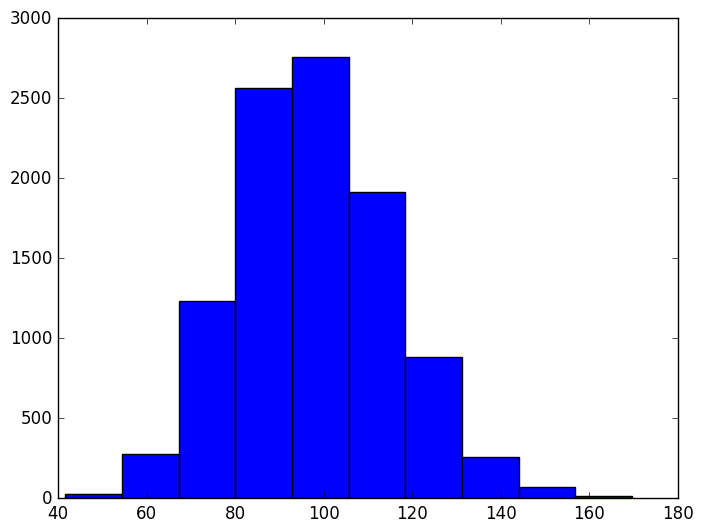

In [3]:
#Problem 1, Part (1)
function time_till_hit(L)
    time = 0
    curr = 2
    while curr != 1
        time += 1
        move = rand()
        if move < 0.5
            curr -= 1
        elseif curr != L
            curr += 1
        end
    end
    return time
end

function mean_time(N, L)
    return mean([time_till_hit(L) for i in 1:N])
end

plt[:hist]([mean_time(1000, 50) for i in 1:10000]);

As expected by the Central Limit Theorem, we get a normal-ish distribution. Given the mean of the histogram, as well as experimenting around a little, we can say that $\mu \approx 2L$. So, $\lim_{x \to \infty}{\mu} = \infty$.

I'm planning on implementing array comprehension and dense matrix methods, and then optimizing the faster of the two. I don't think sparse matrices will be beneficial for the sizes of matrices we will be dealing with.

Since we don't really need to keep track of the entire matrix, just a row and column, it seems wasteful to keep the entire matrix in memory. So, I think the array comprehension approach will be faster... Let's see!

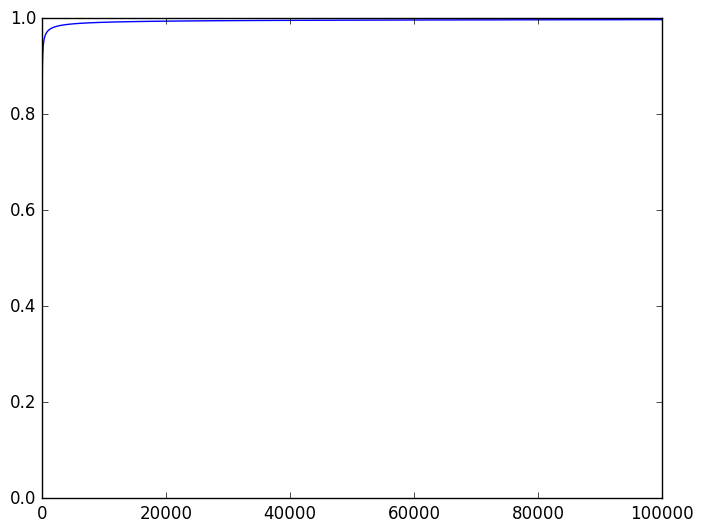

elapsed time: 2.353125719 seconds


In [4]:
#Problem 2, Part (2)

#Array Comprehension
function comp_runner(N, L)
    function comp_evolve(state)
        left = [state[1] + (1 / 2) * state[2]; (1 / 2) * state[3]]
        center = [(1 / 2) * (state[i - 1] + state[i + 1]) for i in 3:(L - 1)]
        right = [(1 / 2) * (state[L - 1] + state[L])]
        return vcat(left, center, right)
    end
    state = zeros(L)
    state[2] = 1
    converge_prob = zeros(N)
    for i in 2:N
        state = comp_evolve(state)
        converge_prob[i] = state[1]
    end
    return converge_prob
end
tic();
probs = comp_runner(100000, 5000);
toc()
plot(probs);

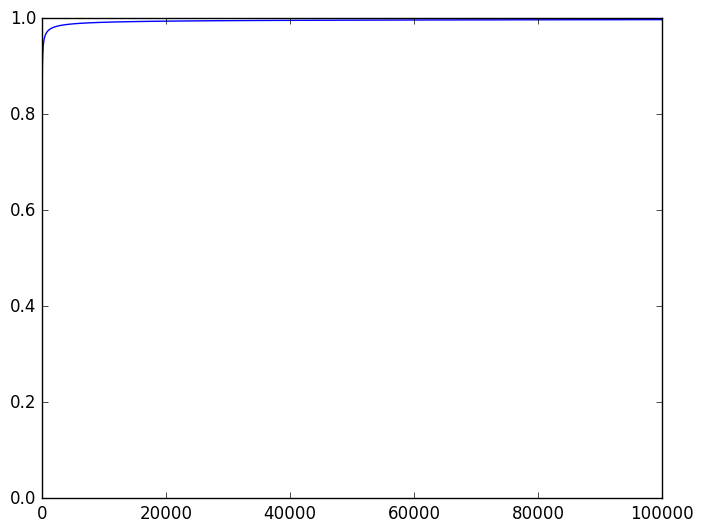

elapsed time: 11.198415416 seconds


In [5]:
#Dense Matrix (sparse benefits only for very, very large N?)
function dense_runner(N, L)
    prob = zeros(N, L)
    prob[1, 2] = 1.0
    for i in 2:N
        prob[i, 1] = prob[i - 1, 1] + 0.5 * prob[i - 1, 2]
        prob[i, 2] = 0.5 * prob[i - 1, 3]
        prob[i, L] = 0.5 * (prob[i - 1, L] + prob[i - 1, L - 1])
        for j in 3:(L - 1)
            prob[i, j] = 0.5 * (prob[i - 1, j - 1] + prob[i - 1, j + 1])
        end
    end
    return prob[:, 1]
end
tic();
probs = dense_runner(100000, 5000);
toc()
plot(probs);

Wow! It isn't even close! I didn't expect this, but it looks like we'll be optimizing the array comprehension!

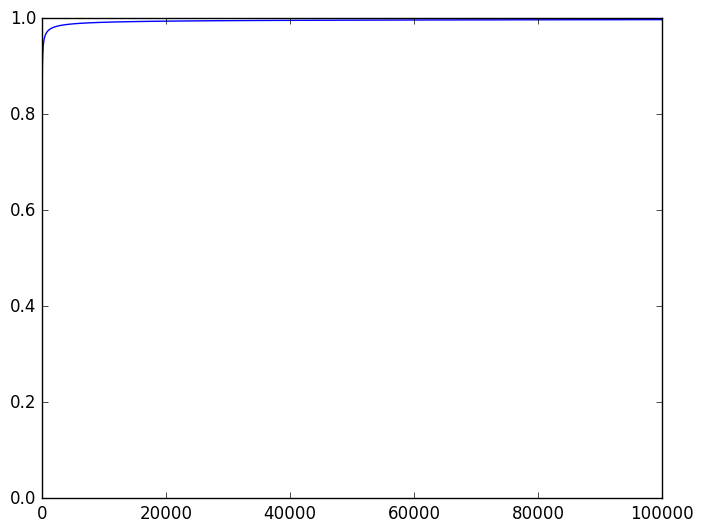

elapsed time: 2.603946752 seconds


In [6]:
#Opt 2
function opt_two_runner(N, L)
    function comp_evolve(state)
        left = [state[1] + (1 / 2) * state[2]; (1 / 2) * state[3]]
        center = [(1 / 2) * (state[i - 1] + state[i + 1]) for i in 3:(L - 1)]
        right = [(1 / 2) * (state[L - 1] + state[L])]
        return vcat(left, center, right)
    end
    state = zeros(L)
    state[2] = 1
    converge_prob = [0.0]
    for i in 2:N
        state = comp_evolve(state)
        push!(converge_prob, state[1])
    end
    return converge_prob
end
tic();
probs = opt_two_runner(100000, 5000);
toc()
plot(probs);

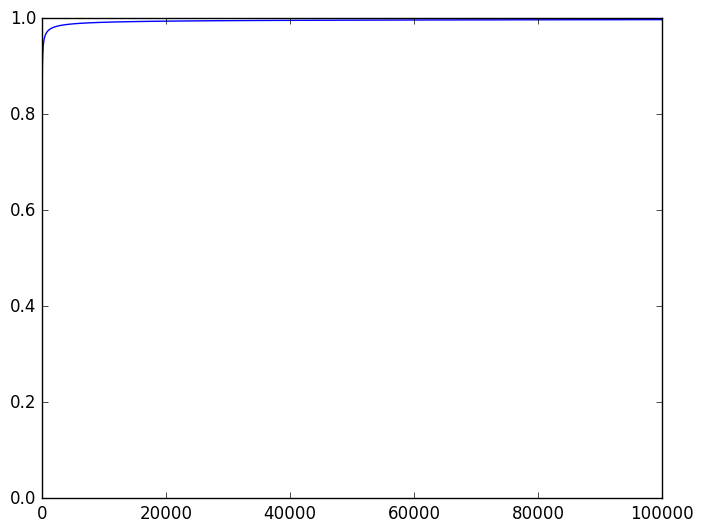

elapsed time: 0.756929759 seconds


In [7]:
#Opt 4
function opt_four_runner(N, L)
    function comp_evolve(state, next)
        next[1] = state[1] + (1 / 2) * state[2]
        next[2] = (1 / 2) * state[3]
        for i = 3:(L - 1)
            next[i] = (1 / 2) * (state[i - 1] + state[i + 1])
        end
        next[L] = (1 / 2) * (state[L - 1] + state[L])
    end
    state = zeros(L)
    state[2] = 1.0
    converge_prob = [0.0]
    next = zeros(N)
    for i in 2:N
        if i % 2 == 0
            comp_evolve(state, next)
            push!(converge_prob, next[1])
        else
            comp_evolve(next, state)
            push!(converge_prob, state[1])
        end
    end
    return converge_prob
end
tic();
probs = opt_four_runner(100000, 5000);
toc()
plot(probs);

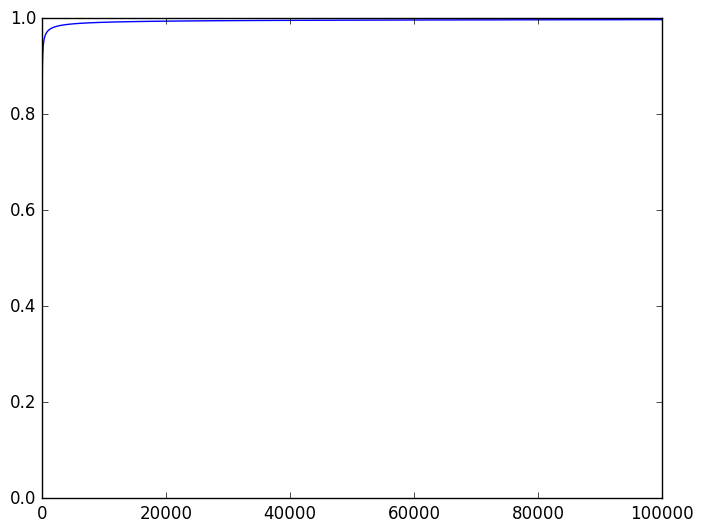

elapsed time: 0.552656227 seconds


In [8]:
#That's way, way faster... Let's see if we can improve it!

#Opt 4
function opt_five_runner(N, L)
    function comp_evolve(state, next)
        next[1] = state[1] + (1 / 2) * state[2]
        next[2] = (1 / 2) * state[3]
        for i = 3:4:(L - 4)
            next[i] = (1 / 2) * (state[i - 1] + state[i + 1])
            next[i + 1] = (1 / 2) * (state[i] + state[i + 2])
            next[i + 2] = (1 / 2) * (state[i + 1] + state[i + 3])
            next[i + 3] = (1 / 2) * (state[i + 2] + state[i + 4])
        end
        next[L] = (1 / 2) * (state[L - 1] + state[L])
    end
    state = zeros(L)
    state[2] = 1.0
    converge_prob = [0.0]
    next = zeros(N)
    for i in 2:N
        if i % 2 == 0
            comp_evolve(state, next)
            push!(converge_prob, next[1])
        else
            comp_evolve(next, state)
            push!(converge_prob, state[1])
        end
    end
    return converge_prob
end
tic();
probs = opt_five_runner(100000, 5000);
toc()
plot(probs);

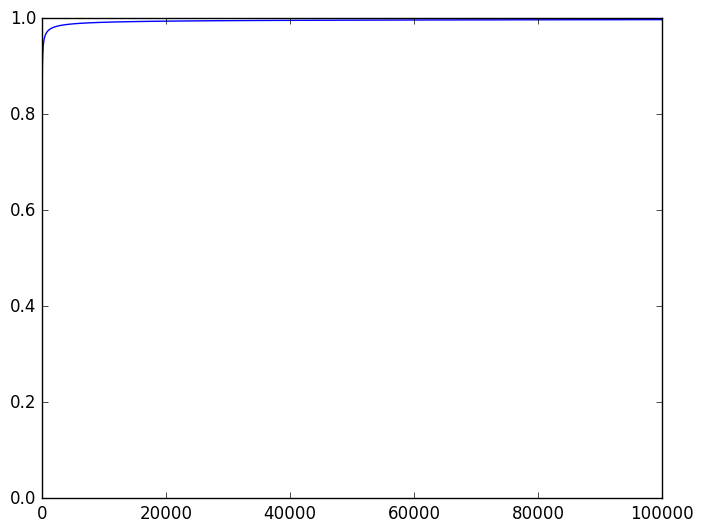

elapsed time: 0.473775648 seconds


In [9]:
#I can't believe loop unrolling actually helped... What else can we do?

#Opt 4
set_zero_subnormals(true)
function opt_five_runner(N, L)
    function comp_evolve(state, next)
        next[1] = state[1] + .5 * state[2]
        next[2] = .5 * state[3]
        @simd for i = 3:4:(L - 4)
            next[i] = .5 * (state[i - 1] + state[i + 1])
            next[i + 1] = .5 * (state[i] + state[i + 2])
            next[i + 2] = .5 * (state[i + 1] + state[i + 3])
            next[i + 3] = .5 * (state[i + 2] + state[i + 4])
        end
        next[L] = .5 * (state[L - 1] + state[L])
    end
    state = zeros(L)
    state[2] = 1.0
    converge_prob = [0.0]
    next = zeros(N)
    for i in 2:N
        if i % 2 == 0
            comp_evolve(state, next)
            push!(converge_prob, next[1])
        else
            comp_evolve(next, state)
            push!(converge_prob, state[1])
        end
    end
    return converge_prob
end
tic();
probs = opt_five_runner(100000, 5000);
toc()
plot(probs);

It looks like SIMD vectorization and set_zero_subnormals(true) didn't do too much, but, overall, we are down from ~2.5 seconds to ~0.5 seconds. The worst implementaiton, using dense arrays took ~15 seconds.

Before benchmarking, sets make sure out code works!

In [55]:
#Can't Reach
@test comp_runner(1, 2) == [0.0]
#50-50
@test comp_runner(3, 3) == [0.0, 0.5, 0.5]
#N = L
@test comp_runner(4, 4) == [0.0, 0.5, 0.5, 0.625]
#Within Epsilon
@test (1 - maximum(comp_runner(500000, 3))) < 0.0000001
#Largest case I did by hand...
@test comp_runner(5, 3) == [0.0, 0.5, 0.5, 0.625, 0.6875]

Test Passed
  Expression: comp_runner(5,3) == [0.0,0.5,0.5,0.625,0.6875]
   Evaluated: [0.0,0.5,0.5,0.625,0.6875] == [0.0,0.5,0.5,0.625,0.6875]

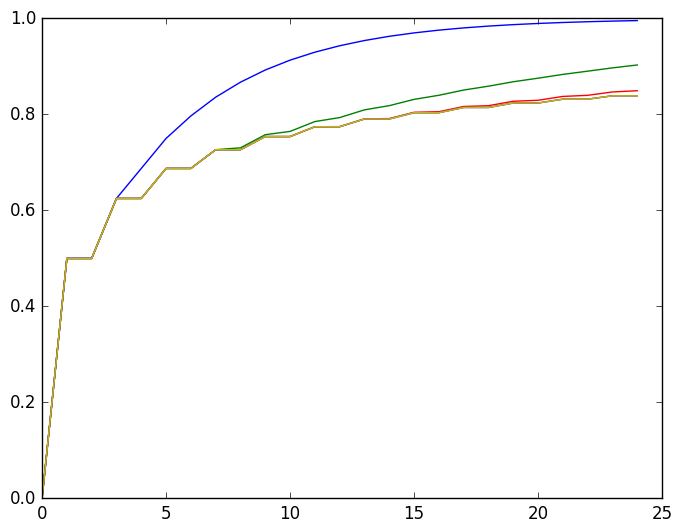

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x309299150>

In [68]:
plot(comp_runner(25, 3))
plot(comp_runner(25, 5))
plot(comp_runner(25, 7))
plot(comp_runner(25, 10))
plot(comp_runner(25, 15))
plot(comp_runner(25, 20))

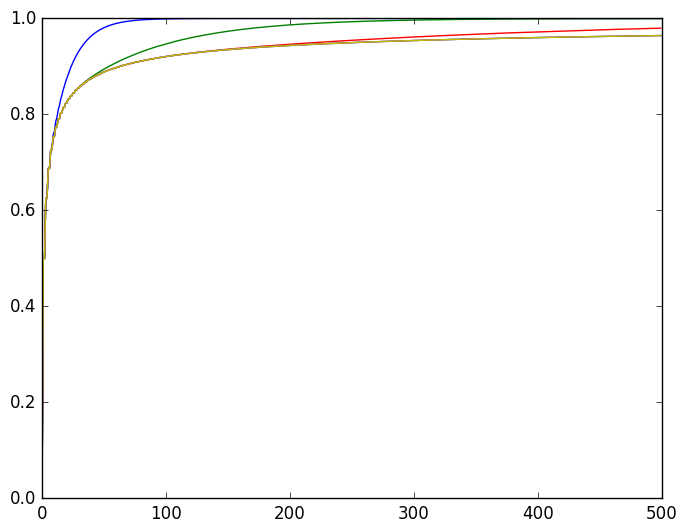

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3205b8890>

In [66]:
plot(comp_runner(500, 5))
plot(comp_runner(500, 10))
plot(comp_runner(500, 20))
plot(comp_runner(500, 50))
plot(comp_runner(500, 100))
plot(comp_runner(500, 250))

The plots are always aymptotic to $1$, since $\lim_{N \to \infty}{P_t} = 1$. However, if we fix a constant $N$, and then increase $L$...

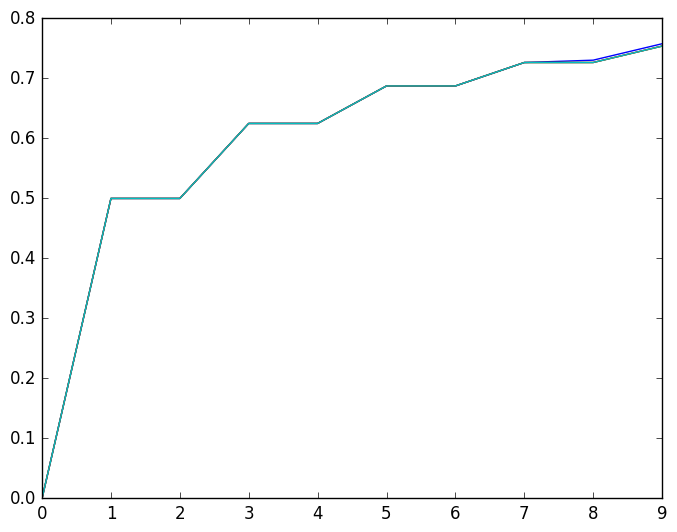

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32351e8d0>

In [73]:
plot(comp_runner(10, 5))
plot(comp_runner(10, 50))
plot(comp_runner(10, 500))
plot(comp_runner(10, 50000000))

The growth rate is slower, as we would expect. Fundamentally, $\min(P_t) = 0.5$, since on the first trial, we can always go left. So, even is $L$ increses without limit, the probabilities will still increase even iteration.

In [10]:
#Problem 2
bench = @benchmarkable opt_five_runner(100000, 5000)
tune!(bench)
run(bench)

BenchmarkTools.Trial: 
  memory estimate:  2.80 mb
  allocs estimate:  22
  --------------
  minimum time:     421.479 ms (0.00% GC)
  median time:      468.477 ms (0.00% GC)
  mean time:        463.954 ms (0.00% GC)
  maximum time:     509.246 ms (0.00% GC)
  --------------
  samples:          11
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%